In [1]:
import dpaleo
import matplotlib.pyplot as plt
import numpy as np

# A simple independent implemention of the UCERF3 workflow.


The following is an informal implementation of the workflow developed by Weldon and Biasi (2013). The workflow is straightforward. While the pertinent steps are exactly implemented, the components (e.g., parameters of lognormal distribution) applied by Weldon and Biasi (2013) are approximated. 


###  1. What is probability that the event is (observable) surface-rupture event?
In practice, this probability would not be merely a function of magnitude. It could well depend on other factors such as location of hypocenter, dip of the fault, and type-of-faulting. However, the magnitude-dependence is reasonable not only for simplicity but also considering region-specific application.

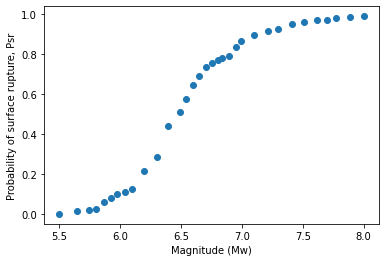

In [2]:
dpaleo.plot_prob_detectsurfrup()

Figure 1. Probability of event (in terms of magnitude) having observable surface rupture.

###  2. What is the average surface slip?

Personally, the linear model connecting magnitude to average surface slip from UCERF3 is awkward. 

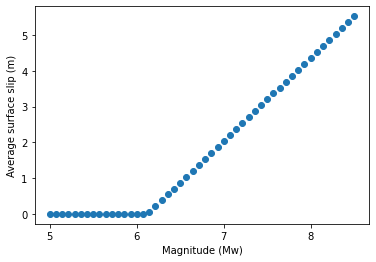

In [3]:
dpaleo.plot_mag2avg_surfslip()

Figure 2. Relation between magniude and average surface slip (Weldon and Biasi, 2013)

###  3. What is the slip profile on the fault?

The average surface slip is distributed according to a sinesqrt function.

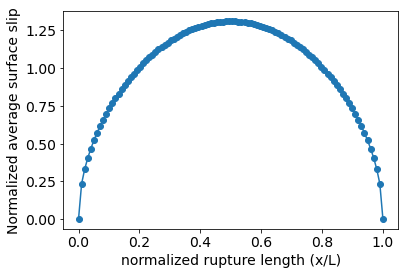

In [4]:
dpaleo.plot_sinesqrt()

Figure 3. Normalized along-strike slip profile

###  4. What is distribution of normalized average surface slip at an along-strike point on the fault-rupture?

UCERF3 applies lognormal distribution, I'd prefer extreme value distribution (Thingbaijam et al., 2022). However, it remains to see how does that affect the results.

First, let us look at an example distribution

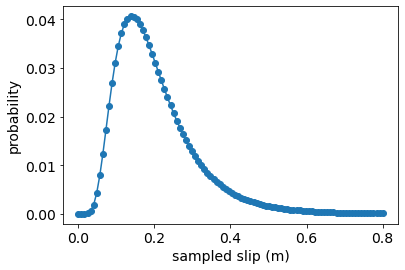

In [5]:
sampledslip, sampledslipprob = dpaleo.prob_slip_profpoint (0.2, normx=None, model = "UCERF3")

plt.plot(sampledslip, sampledslipprob, 'o-')
plt.xlabel('sampled slip (m)');
plt.ylabel('probability');

Figure 4. An example depicting lognormal distribution of normalized average slip at a point along strike of fault-rupture

#### It might be useful to understand the implication of probability distribution function (PDF).

We consider integration over PDF through summation,
<br></br>
$P_{TD, total}$($u_{x}$) = $\sum_{i=1}^{n}$ $P_{tD}$($u_{x,i}$) $P_{x}$($u_{xi}$) &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(1)
<br></br>
which gives the probability of detecting slip ($u_{x}$) at the trench ( or detectability of paleo-slip) for surface-rupture event

### 5. What is the probability of detecting paleo-slip at the trench?

THe figure given below is what I refer to as "The Wrightwood model" (Table from UCERF Appendix I). UCERF3 employs linear interpolation on these data points as is in this workout. However, I believe an exponential model can be easily formulated which would just do fine.

We still have to consider the proability of being a surface-rupture event. Complete formulation is as follows:
<br></br>
$P_{paleoslip}$($u_{x}$) = $\sum_{i=1}^{n}$ $P_{tD}$($u_{x,i}$) $P_{x}$($u_{xi}$) $P_{SR}$ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;    (2)
<br></br>

which gives the detectability of ground-rupture at paleoseismic sites.



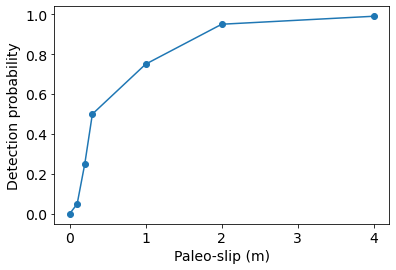

In [6]:
dpaleo.plot_prob_detect_paleoslip(model="wrightwood2013")

Figure 5. The Wrightwood model for probabilty of detecting slip at paleoseismic site. 


An exponential model fits the Wrightwood observations quite nicely, which is given by p = 1-np.exp(-1.6*u), where p is probability of dectecting paleo-slip while u is slip (in m).However, UCERF3 uses 1-D interpolation.



In [14]:
def compute_prob_detectpaleoslip(mag):
   # get prob of being observble surface-rupture event
    P_sr = dpaleo.prob_detectsurfrup(magnitude=mag, model="UCERF3")

    # get average surface slip
    avg_surfslip = dpaleo.mag2avg_surfslip(magnitude=mag, model="UCERF3")

    # get surface slip profile
    norm_x =np.linspace(0.05, 0.5,50)
    slip_x = dpaleo.slip_profile(avg_surfslip, x_by_RL=norm_x, model="sinesqrt")


    prob_paleo_detect = []

    # slip_x is slip profile
    for ii in range(len(slip_x)): 
        sampledslip, slipprob = dpaleo.prob_slip_profpoint(slip_x[ii], normx=norm_x[ii], model = "UCERF3")
    
        prob_td_x = [] # prob of being detectable at the paleo trench
        for jj in range(len(sampledslip)):
            # model="wrightwood2013"
            temp = dpaleo.prob_detectpaleoslip(sampledslip[jj], prob_sampledslip = slipprob[jj])
            prob_td_x.append(temp)
    
        prob_td = sum(prob_td_x)
        prob_paleo_detect.append(prob_td*P_sr)
        
    return (norm_x, prob_paleo_detect)

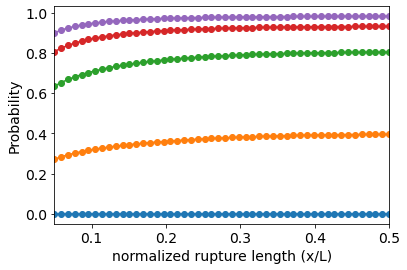

In [26]:
mag = [6.0, 6.5, 7.0, 7.5, 8.0]
#mag = np.arange(5.0, 8.25, 0.05)
for i in range(len(mag)):
    norm_x, prob_paleo_detect = compute_prob_detectpaleoslip(mag[i])
    plt.plot(norm_x, prob_paleo_detect, 'o-')

plt.xlim([0.05, 0.5])
plt.xlabel('normalized rupture length (x/L)');
plt.ylabel('Probability');


#### Reference:

Thingbaijam  KKS,  Van  Dissen  RJ,  Shaw  BE,  Gerstenberger  MC. 2022. Average coseismic slip profiles. Lower Hutt (NZ): GNS Science.33p.(GNS Science report;2021/24). doi:10.21420/S6ED-JN06

Weldon RJ, Biasi GP. Appendix I: Probability of detection of ground rupture at paleoseismic sites.  US Geol. Surv. Open‐File Rept. 2013‐1165‐I, and California Geol. Surv. Special Rept. 228‐I. 2013.
 
 -----------------------------------------------------------------------------------